In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lab2_proto import *
from prondict import prondict
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Performance measuring
import psutil
import time

# 3) Data and Model set

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [3]:
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
phoneHMMs['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

# 4) Concatenating HMMs

In [5]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

selected_digit = 'o'

print(isolated[selected_digit])

['sil', 'ow', 'sil']


In [6]:
wordHMMs = {}
wordHMMs[selected_digit] = concatHMMs(phoneHMMs, isolated[selected_digit])

In [7]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

In [8]:
means = wordHMMs[selected_digit]['means']
covars = wordHMMs[selected_digit]['covars']
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], means, covars)
#(example['obsloglik'] - log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars']))[:4]

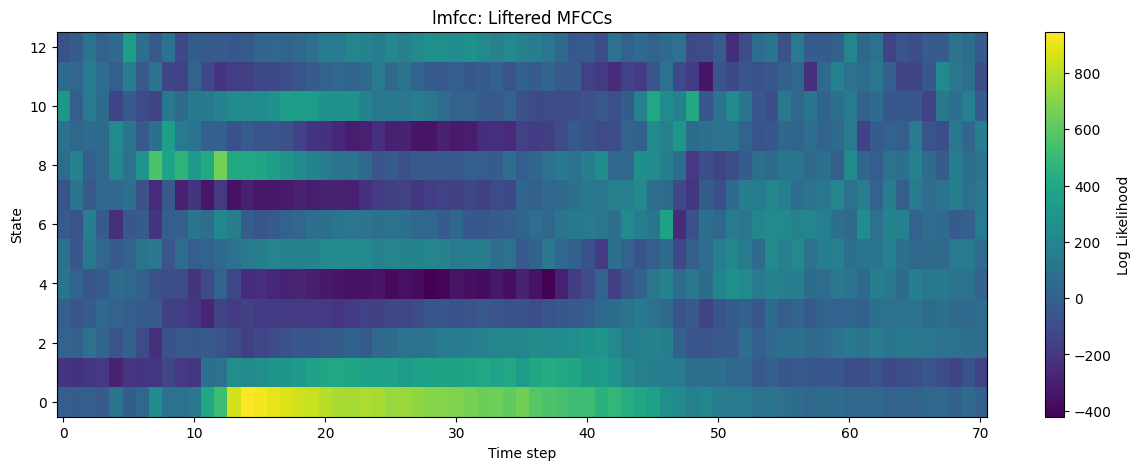

In [9]:
plt.figure(figsize=(15, 5))
plt.imshow(example['lmfcc'].T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('lmfcc: Liftered MFCCs')
plt.show()

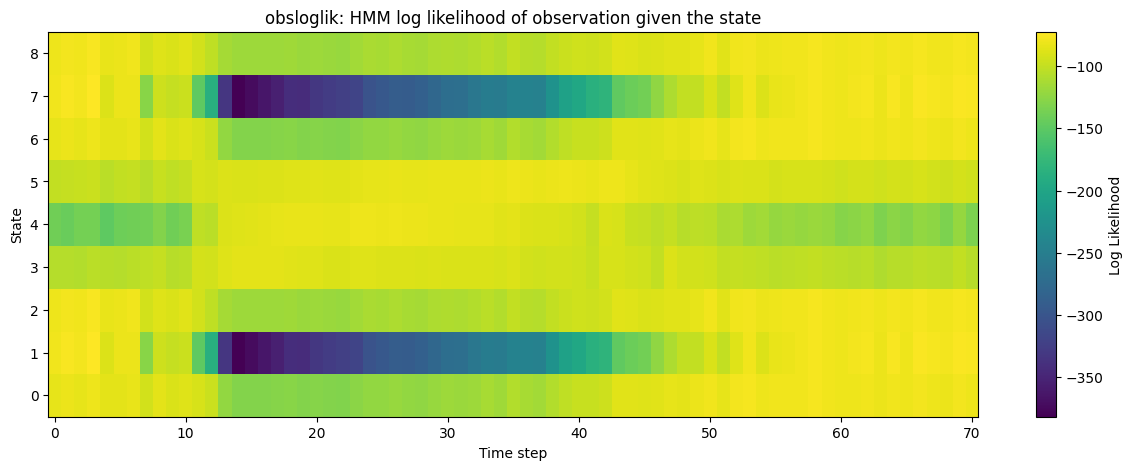

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(obsloglik.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('obsloglik: HMM log likelihood of observation given the state')
plt.show()

* What can you say about the figure? \
It shows the likelihood of observing a phoneme, given the signal/sound?.
Our phonemes begin and end with "sil" (silence) and thus the highest likelihood resembles an "X".

* Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence. \
The components around the middle (3-5, making up the actual word, in case of "o" -> "ow"), in time stamps from ~13 to ~43. These phonemes are unlikely in the early and late time steps that represent silence.
The components before and after (the silence components) have a higher likelihood in the early and late time steps.

In [11]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# 5.2) Forward algorithm - Evaluate an HMM

The Forward algorithm is a dynamic programming approach to calculate the likelihood P(X|theta) of an observation sequence X = (X1, X2, ..., XT) given the HMM theta. The algorithm proceeds sequentially over the sequence, computing forward probabilities that represent the joint probability of observing a particular subsequence of data and being in a specific state of the model at each time step.

In [12]:
logalpha = forward(example['obsloglik'], np.log(wordHMMs[selected_digit]['startprob']), np.log(wordHMMs[selected_digit]['transmat']))
#logalpha - example['logalpha']

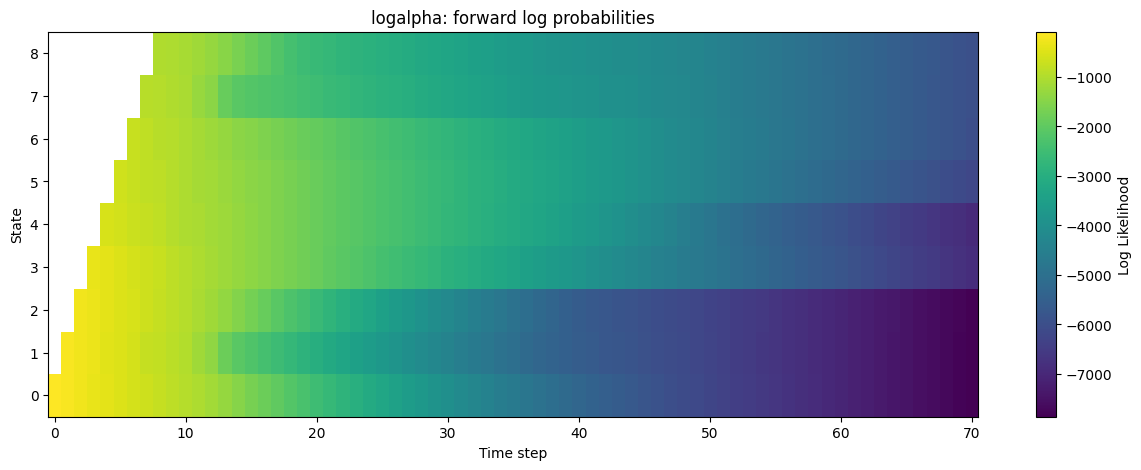

In [13]:
plt.figure(figsize=(15, 5))
plt.imshow(logalpha.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('logalpha: forward log probabilities')
plt.show()

In [14]:
word_hmms = {}
for digit in prondict.keys():
    word_hmms[digit] = concatHMMs(phoneHMMs, ['sil'] + prondict[digit] + ['sil'])

data = np.load('lab2_data.npz', allow_pickle=True)['data']
#data.shape # (44,)

In [15]:
# TODO: find better ways of measuring performance
# Start measuring performance
start_cpu = psutil.cpu_percent(interval=None)
start_time = time.time()

optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        logalpha = forward(obsloglik, np.log(startprob), np.log(transmat))
        loglik = logsumexp(logalpha[-1])

        if max_log_likelihood is None or max_log_likelihood < loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1
    else:
        print(f"Expected digit: {df['digit']}, predicted instead digit: {optimal_hmm[i]}")

acc = np.round(successful_pred / len(data) * 100, 1)
print("Accuracy forward algorithm: " + str(acc))

# Finish measuring performance
end_cpu = psutil.cpu_percent(interval=None)
end_time = time.time()

cpu_usage = end_cpu - start_cpu
time_elapsed = end_time - start_time

print(f"CPU usage: {cpu_usage}%")
print(f"Time elapsed: {time_elapsed} seconds")

Expected digit: 9, predicted instead digit: 1
Accuracy forward algorithm: 97.7
CPU usage: 3.5%
Time elapsed: 18.1869215965271 seconds


## Single speaker

In [16]:
single_phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
ss_word_hmms = {}
for digit in prondict.keys():
    ss_word_hmms[digit] = concatHMMs(single_phoneHMMs, ['sil'] + prondict[digit] + ['sil'])

In [17]:
optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in ss_word_hmms.keys():
        means, covars = ss_word_hmms[digit]['means'], ss_word_hmms[digit]['covars']
        startprob, transmat = ss_word_hmms[digit]['startprob'], ss_word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        logalpha = forward(obsloglik, np.log(startprob), np.log(transmat))
        loglik = logsumexp(logalpha[-1])

        if max_log_likelihood is None or max_log_likelihood < loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1
    else:
        print(f"Expected digit: {df['digit']}, predicted instead digit: {optimal_hmm[i]}")

acc = np.round(successful_pred / len(data) * 100, 1)
print("Accuracy forward algorithm: " + str(acc))

Expected digit: 1, predicted instead digit: 3
Expected digit: 1, predicted instead digit: 9
Expected digit: 2, predicted instead digit: 3
Expected digit: 5, predicted instead digit: 3
Expected digit: 5, predicted instead digit: 3
Expected digit: 7, predicted instead digit: 3
Expected digit: 7, predicted instead digit: 3
Expected digit: 8, predicted instead digit: 3
Expected digit: 8, predicted instead digit: 3
Expected digit: 9, predicted instead digit: z
Accuracy forward algorithm: 77.3


* Do you see any mistakes if you take the maximum likelihood model as winner? \
If we train using all the speakers, we identify a single mistake - mistakanely identified a "9" as "1". 

* Compare the results obtained from the models trained on a single speaker or all the training speakers. \
Training the model on all speakers results in a higher accuracy (difference in accuracy ~0.2).
Training using only the single speaker, the model is eager to predict "3", which is the source of most errors. 

# 5.3) Viterbi algorithm - Decode an HMM

The Viterbi algorithm is a dynamic programming algorithm for finding the most probable sequence of hidden states—called the Viterbi path—that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models (HMM).

In [18]:
# Start measuring performance
start_cpu = psutil.cpu_percent(interval=None)
start_time = time.time()

optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(startprob), np.log(transmat))
        if max_log_likelihood is None or max_log_likelihood < viterbi_loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = viterbi_loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1

acc = np.round(successful_pred / len(data) * 100, 1)
print("The accuracy of the predictions has been: " + str(acc))

# Finish measuring performance
end_cpu = psutil.cpu_percent(interval=None)
end_time = time.time()

cpu_usage = end_cpu - start_cpu
time_elapsed = end_time - start_time

print(f"CPU usage: {cpu_usage}%")
print(f"Time elapsed: {time_elapsed} seconds")

The accuracy of the predictions has been: 100.0
CPU usage: -0.10000000000000142%
Time elapsed: 7.561161041259766 seconds


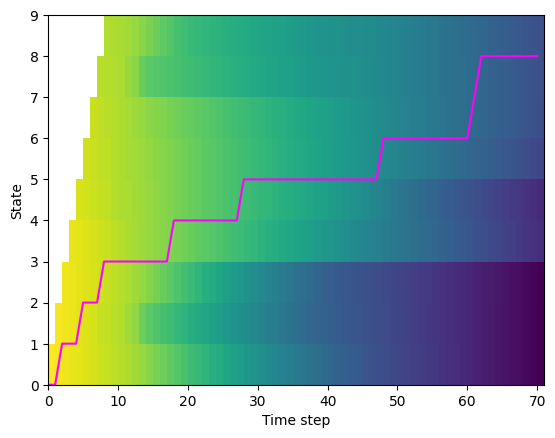

In [19]:
startprob_o = word_hmms[selected_digit]['startprob']
transmat_o = word_hmms[selected_digit]['transmat']

logalpha = forward(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))
vloglik, viterbi_path = viterbi(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))

plt.pcolormesh(logalpha.T)
plt.plot(viterbi_path.T, color="magenta")
plt.xlabel('Time step')
plt.ylabel('State')
plt.show()

* Can you explain the reason why the path looks this way? \
The Viterbi path shows the best hidden sequence - most probable observed sequence of phonemes.
As the most probable areas are the lightest ones, it is observable how the path travels through the most probable areas/cells of the color mesh plot.

* How many mistakes can you count if you take as winner the model with the maximum viterbi score? Are these the same mistakes obtained in previous section? \
We don't encounter any mistakes, not even the single one encountered using the Forward algorithm.
For the single speaker, the number of mistakes is the same (10).

* Can you say something about the complexity of the viterbi scoring compared to the forward scoring (for example by measuring the CPU usage?) \
(Elaborate on the complexity in more theoretical terms)
The forward algorithm takes more time and has a higher CPU usage as well.

# 5.4) Backward Algorithm

The backward algorithm in Hidden Markov Models (HMMs) is a dynamic programming algorithm used to calculate the probability of the future data given a current state. This probability is called the backward probability. The backward algorithm is closely related to the forward algorithm, but instead of starting at the beginning of the observed sequence and moving forwards, it starts at the end and moves backwards.

In [20]:
# using example
logbeta = backward(example['obsloglik'], np.log(wordHMMs[selected_digit]['startprob']), np.log(wordHMMs[selected_digit]['transmat']))
logbeta - example['logbeta']

array([[-1.43241049e-02,  3.26782594e-01,  3.99795393e-01,
         4.13029080e-01,  9.53554095e-01,  6.03007243e-01,
         2.89606005e+00,  1.13045494e+00,  1.20346774e+00],
       [-3.97518855e-02,  2.99397870e-01,  3.82602997e-01,
         4.05990986e-01,  9.48474994e-01,  5.97928142e-01,
         2.84337775e+00,  1.10307021e+00,  1.18627534e+00],
       [-4.75696169e-02,  2.87944165e-01,  3.65410601e-01,
         3.98952892e-01,  9.43395892e-01,  5.92849040e-01,
         2.79069545e+00,  1.09161651e+00,  1.16908294e+00],
       [-2.92751219e-02,  2.80629570e-01,  3.48218205e-01,
         3.91914798e-01,  9.38316790e-01,  5.87769939e-01,
         2.73801314e+00,  1.08430191e+00,  1.15189055e+00],
       [-8.19574190e-02,  2.58128586e-01,  3.31025809e-01,
         3.84876705e-01,  9.33237689e-01,  5.82690837e-01,
         2.68533084e+00,  1.06180079e+00,  1.13469815e+00],
       [-6.44996365e-02,  2.46244810e-01,  3.13833412e-01,
         3.77838611e-01,  9.28158587e-01,  5.776117

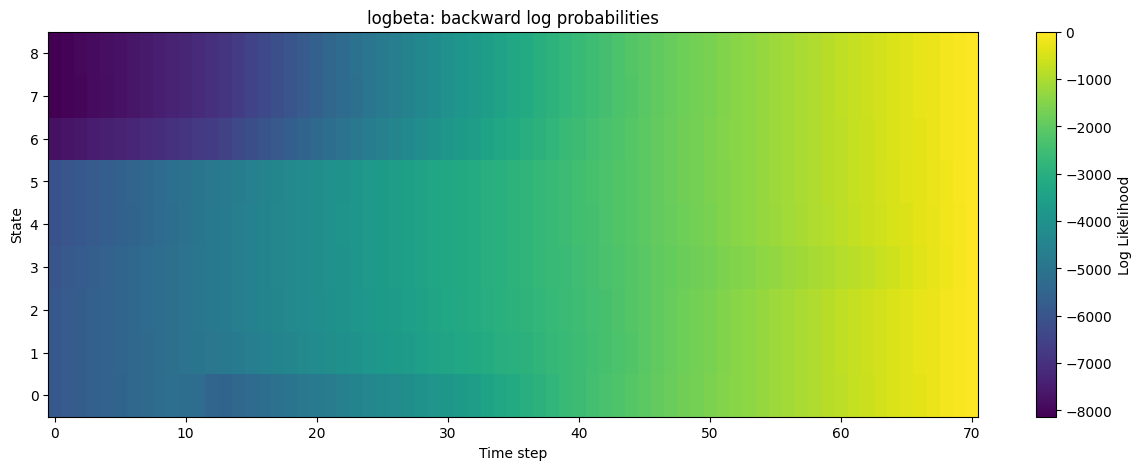

In [21]:
plt.figure(figsize=(15, 5))
plt.imshow(logbeta.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('logbeta: backward log probabilities')
plt.show()

# 6) HMM Retraining (emission probability distriubtions)

## 6.1 State posterior probabilities

In [22]:
log_gamma = statePosteriors(logalpha, logbeta)

tolerance = 1e-10

# Verify that for each time step the state posteriors sum to one (in linear domain)
for gamma_entry in log_gamma:
    time_step_state_posterior = np.sum(np.exp(gamma_entry))     
    assert np.isclose(time_step_state_posterior, 1, atol=tolerance), f"Sum {time_step_state_posterior} is not 1"

# Sum posteriors for each state
for gamma_entry in log_gamma.T:
    state_posterior = np.sum(np.exp(gamma_entry))     
    print(state_posterior)

# The sum over both time steps as well as state posteriors
np.sum(np.exp(log_gamma))

1.3557096955406696
2.083841430370396
3.560484896504479
9.756423772042526
10.023745046499327
20.599383429603833
13.029562434023344
1.2059598571159604
9.384889437942961


70.99999999964349

* Now sum the HMM posteriors (in linear domain) for each state along the time axis. What is the meaning the the values you obtain?

These values represent the expected number of transition to/from state i (S_i). This showcases which states are expected to be the most active during the sequence.

* What about summing over both states and time steps? Compare this number to the length of the observation sequence.

The sum over both time steps and states (I.e. the sum of the number of all expected transitions to each state) results in the number of time steps (length of the observation sequence = 71 for "o"). Which makes sense, we expect 1 transition per 1 time step.

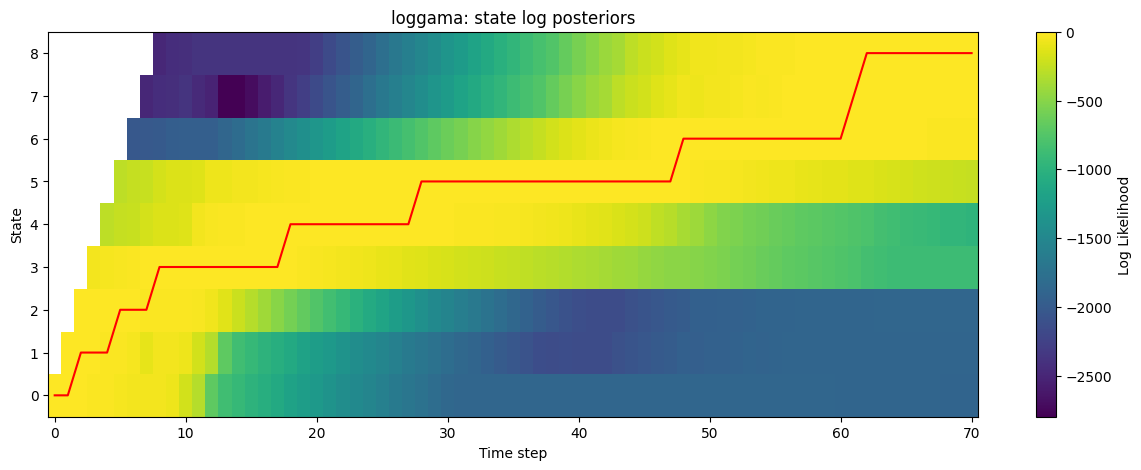

In [23]:
plt.figure(figsize=(15, 5))
plt.imshow(log_gamma.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.plot(viterbi_path.T, color="red")
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('loggama: state log posteriors')
plt.show()

6.859165790827855
6.381371733996248
5.268882046673664
3.6408977892090144
13.573972082947567
16.76629098484793
6.859165790827855
6.381371733996248
5.268882046673664


Text(0.5, 1.0, 'GMM: state log posteriors')

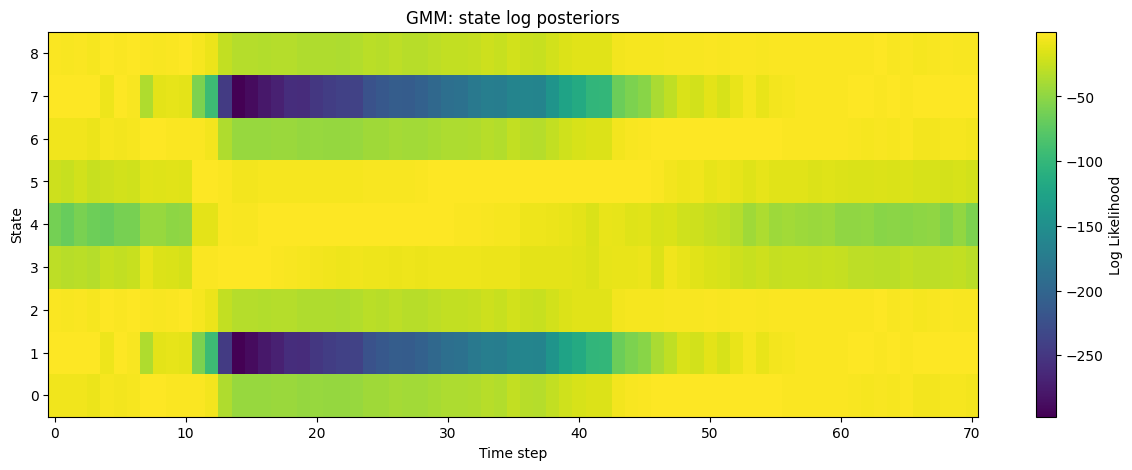

In [24]:
GMM_state_posterior = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs[selected_digit]["means"], wordHMMs[selected_digit]["covars"])

# Compute for each time step
for i in range(GMM_state_posterior.shape[0]):
    # Normalize
    GMM_state_posterior[i, :] -= logsumexp(GMM_state_posterior[i, :])

# Sum posteriors for each state
for gmm_entry in GMM_state_posterior.T:
    state_posterior = np.sum(np.exp(gmm_entry))     
    print(state_posterior)

# print(np.sum(np.exp(GMM_state_posterior)))

plt.figure(figsize=(15, 5))
plt.imshow(GMM_state_posterior.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('GMM: state log posteriors')

Compare qualitatively the HMM and GMM posteriors. What is the difference? Why? 
- answer

What is the effect of the transition model in the HMM combined with the more complex 
way of computing the state posteriors?
- answer

## 6.2 Retraining the emission probability distributions

Max Log-likelihood: -5682.161964496222. Best digit model: 7


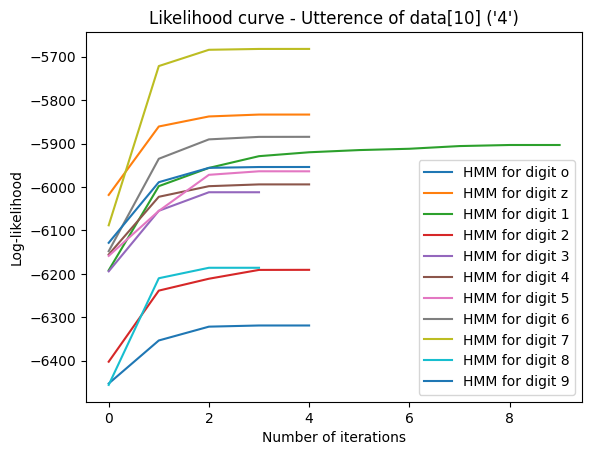

In [25]:
MAX_ITER = 20
THRESHOLD = 1.0

utterance = data[10]

max_loglik, best_digit = None, None

plt.figure()
for digit, params in word_hmms.items():
    logliks = []
    means, covars = params['means'], params['covars']
    startprob_log = np.log(params['startprob'])
    transmat_log = np.log(params['transmat'])

    obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], means, covars)
    newloglik = viterbi(obsloglik, startprob_log, transmat_log)[0]

    i = 0
    while i < MAX_ITER and abs(newloglik - viterbi_loglik) > THRESHOLD:
        viterbi_loglik = newloglik
        
        log_alpha = forward(obsloglik, startprob_log, transmat_log)
        log_beta = backward(obsloglik, startprob_log, transmat_log)
        log_gamma = statePosteriors(log_alpha, log_beta)

        means, covars = updateMeanAndVar(utterance['lmfcc'], log_gamma)
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], means, covars)
        newloglik = viterbi(obsloglik, startprob_log, transmat_log)[0]
        logliks.append(newloglik)
        i += 1
    
    plt.plot(logliks, label='HMM for digit {}'.format(digit))
    plt.xlabel('Number of iterations')
    plt.ylabel('Log-likelihood')
    plt.title("Likelihood curve - Utterence of data[10] ('4')")

    if max_loglik is None or newloglik > max_loglik:
        max_loglik = newloglik
        best_digit = digit
        
plt.legend()
print(f"Max Log-likelihood: {max_loglik}. Best digit model: {best_digit}")


* Can you say anything about the log likelihood at each iteration and the
number of iterations that are required to terminate the algorithm?

At each iteration the log likelihood is increasing, as we are learning. Most models plateau/find the local optimum at iteration 4, apart for model for digit "1". This model continues learning, but it's visible that not by much.